# HOUSE PRICE PREDICTION

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Download latest version
path = kagglehub.dataset_download("derrekdevon/real-estate-sales-2001-2020")

print("Path to dataset files:", path)

# Load data
file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, file))


Path to dataset files: /Users/howey/.cache/kagglehub/datasets/derrekdevon/real-estate-sales-2001-2020/versions/1


### Data preprocessing

In [2]:

# ---- Quick info ----

print("== LOADED ROWS:", df.shape[0], "COLUMNS:", df.shape[1])
print(df.head())

print("\n== INFO == ")
df.info()
print("\n== BASIC SUMMARY STATS ==")
print(df.describe())



== LOADED ROWS: 997213 COLUMNS: 11
   Serial Number  List Year Date Recorded     Town                Address  \
0        2020348       2020     9/13/2021  Ansonia        230 WAKELEE AVE   
1          20002       2020     10/2/2020  Ashford        390 TURNPIKE RD   
2         200212       2020      3/9/2021     Avon       5 CHESTNUT DRIVE   
3         200243       2020     4/13/2021     Avon  111 NORTHINGTON DRIVE   
4         200377       2020      7/2/2021     Avon     70 FAR HILLS DRIVE   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0          150500     325000.0       0.4630    Commercial              Nan   
1          253000     430000.0       0.5883   Residential    Single Family   
2          130400     179900.0       0.7248   Residential            Condo   
3          619290     890000.0       0.6958   Residential    Single Family   
4          862330    1447500.0       0.5957   Residential    Single Family   

   Years until sold  
0          

In [3]:
# Years until sold.min() = -18 ??
print(df[df['Years until sold'] < 0][['List Year', 'Date Recorded']].head())

        List Year Date Recorded
388498       2006     2/26/2004
389700       2006      9/4/2001
407732       2006     7/17/2003
409330       2006     9/20/2005
410449       2006     9/25/2001


In [4]:
# Check Property Types and Residential Types
print("== PROPERTY TYPES ==")
print(df['Property Type'].unique())
print("\n== RESIDENTIAL TYPES ==")
print(df['Residential Type'].unique())

== PROPERTY TYPES ==
['Commercial' 'Residential' 'Vacant Land' 'Nan' 'Apartments' 'Industrial'
 'Public Utility' 'Condo' 'Two Family' 'Three Family' 'Single Family'
 'Four Family']

== RESIDENTIAL TYPES ==
['Nan' 'Single Family' 'Condo' 'Two Family' 'Three Family' 'Four Family']


In [5]:
for prop in df['Property Type'].unique():
  print(f"== {prop} ==")
  print(df[df['Property Type']== prop].sort_values(by='Property Type', ascending=False).head())
  print('\n')

== Commercial ==
       Serial Number  List Year Date Recorded          Town  \
0            2020348       2020     9/13/2021       Ansonia   
43135         200584       2020     3/22/2021     New Haven   
43057          20427       2020      4/9/2021       Newtown   
43027        2002395       2020     8/18/2021      Stamford   
43022       20200014       2020    12/14/2020  North Canaan   

                         Address  Assessed Value  Sale Amount  Sales Ratio  \
0                230 WAKELEE AVE          150500     325000.0     0.463000   
43135               9 ATWATER ST          261100     465000.0     0.561505   
43057  178-180 MAIN STREET SOUTH          242960     200000.0     1.214800   
43027      365 SYLVAN KNOLL ROAD        11259520     178500.0    63.078500   
43022        176 ASHLEY FALLS RD          134780     229000.0     0.588500   

      Property Type Residential Type  Years until sold  
0        Commercial              Nan                 1  
43135    Commercial  

In [6]:
# Clean data
def process_data(df):

    # Dates
    df['Date Recorded'] = pd.to_datetime(df['Date Recorded'], errors='coerce')
    invalid_years = df['List Year'] > df['Date Recorded'].dt.year
    df.loc[invalid_years, 'List Year'] = df.loc[invalid_years, 'Date Recorded'].dt.year
    df['Year Sold'] = df['Date Recorded'].dt.year
    df['Years until sold'] = df['Date Recorded'].dt.year.values - df['List Year'].values

    # Property and Residential types
    df['Property Type'] = df['Property Type'].replace('Nan', 'Other')
    df['Residential Type'] = df['Residential Type'].replace('Nan', 'N/A')

    residential_types = ['Single Family', 'Condo', 'Two Family', 'Three Family', 'Four Family',
        'Vacant Land', 'Apartments']
    for r_type in residential_types:
      df.loc[df['Property Type'].isin([r_type]), 'Residential Type'] = r_type

    df.loc[df['Property Type'].isin(residential_types), 'Property Type'] = 'Residential'


    df[['Property Type', 'Residential Type']] = df[['Property Type', 'Residential Type']].astype('category')


    return df

In [7]:
df_1 = process_data(df)
print(df_1.head())

   Serial Number  List Year Date Recorded     Town                Address  \
0        2020348       2020    2021-09-13  Ansonia        230 WAKELEE AVE   
1          20002       2020    2020-10-02  Ashford        390 TURNPIKE RD   
2         200212       2020    2021-03-09     Avon       5 CHESTNUT DRIVE   
3         200243       2020    2021-04-13     Avon  111 NORTHINGTON DRIVE   
4         200377       2020    2021-07-02     Avon     70 FAR HILLS DRIVE   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0          150500     325000.0       0.4630    Commercial              N/A   
1          253000     430000.0       0.5883   Residential    Single Family   
2          130400     179900.0       0.7248   Residential            Condo   
3          619290     890000.0       0.6958   Residential    Single Family   
4          862330    1447500.0       0.5957   Residential    Single Family   

   Years until sold  Year Sold  
0                 1       2021  
1 

In [8]:
print(df_1[['Property Type', 'Residential Type']].value_counts())

Property Type   Residential Type
Residential     Single Family       445016
Other           N/A                 382446
Residential     Condo               117780
                Two Family           29609
                Three Family         14081
                Vacant Land           3163
                Four Family           2418
Commercial      N/A                   1981
Residential     Apartments             486
Industrial      N/A                    228
Public Utility  N/A                      5
Name: count, dtype: int64


In [9]:
print(df_1.describe())

       Serial Number      List Year                  Date Recorded  \
count   9.972130e+05  997213.000000                         997213   
mean    4.311864e+05    2010.189609  2011-06-19 11:36:47.021769216   
min     0.000000e+00    1999.000000            1999-04-05 00:00:00   
25%     3.044400e+04    2004.000000            2005-07-25 00:00:00   
50%     7.030300e+04    2010.000000            2011-01-19 00:00:00   
75%     1.518780e+05    2016.000000            2017-04-05 00:00:00   
max     2.000500e+09    2020.000000            2021-09-30 00:00:00   
std     6.549219e+06       6.237850                            NaN   

       Assessed Value   Sale Amount   Sales Ratio  Years until sold  \
count    9.972130e+05  9.972130e+05  9.972130e+05     997213.000000   
mean     2.791437e+05  3.911512e+05  1.044637e+01          0.751119   
min      0.000000e+00  0.000000e+00  0.000000e+00          0.000000   
25%      8.760000e+04  1.400000e+05  4.867000e-01          1.000000   
50%      1.383

### EDA

Text(0.5, 1.0, 'Average Sale Price and Assessed amount by Year')

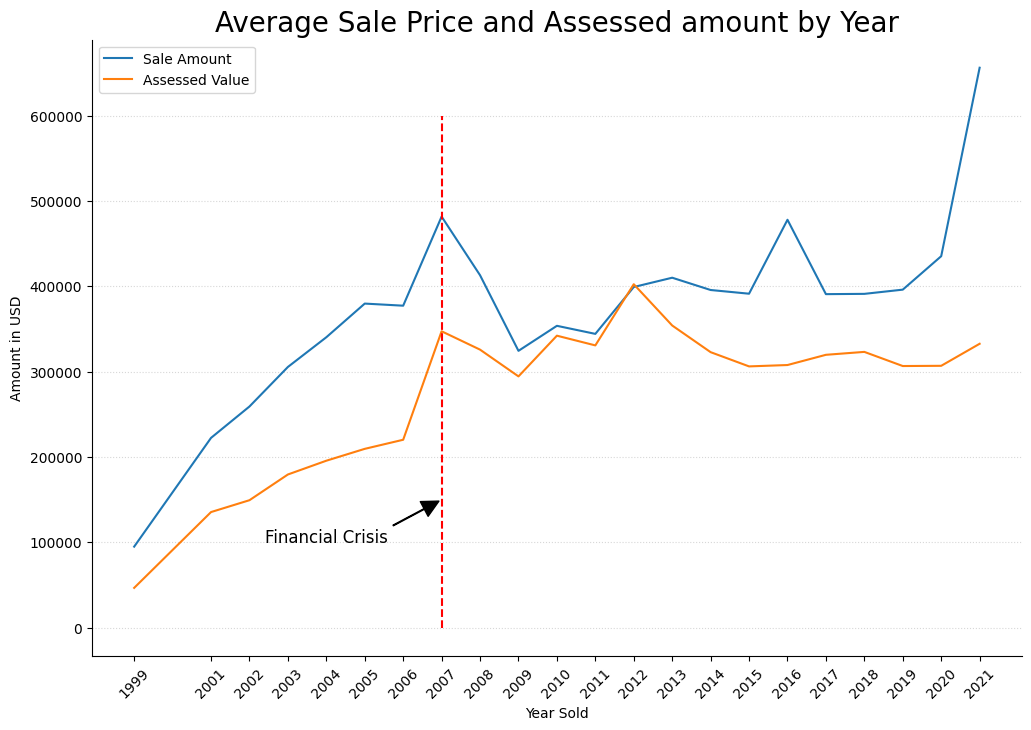

In [10]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df_1,x='Year Sold',y='Sale Amount',errorbar=None,label='Sale Amount')
sns.lineplot(data=df_1,x='Year Sold',y='Assessed Value',errorbar=None,label='Assessed Value')

plt.xticks(df_1['Year Sold'].unique(),rotation=45)
plt.vlines(2007,ymin=0,ymax=600000,ls='--',color='red')
plt.annotate('Financial Crisis', xy=(2007, 150000), xytext=(2004, 100000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=12, ha='center')
sns.despine(top=True, right=True)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.legend()
plt.ylabel("Amount in USD")
plt.title('Average Sale Price and Assessed amount by Year',fontsize=20)

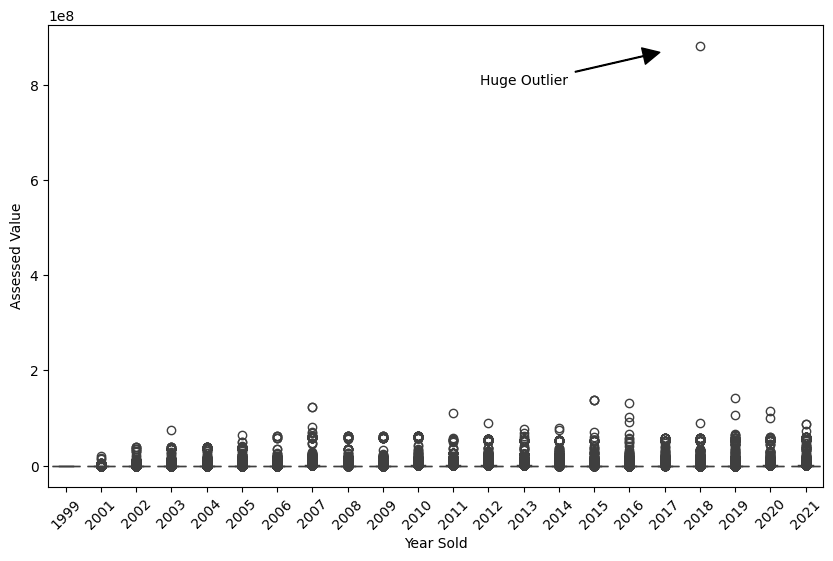

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_1,x='Year Sold',y='Assessed Value',)
plt.annotate('Huge Outlier', xy=(17, 870000000), xytext=(13, 800000000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=10, ha='center')
plt.xticks(rotation=45);

Text(15, 5000000000, 'Huge Outlier')

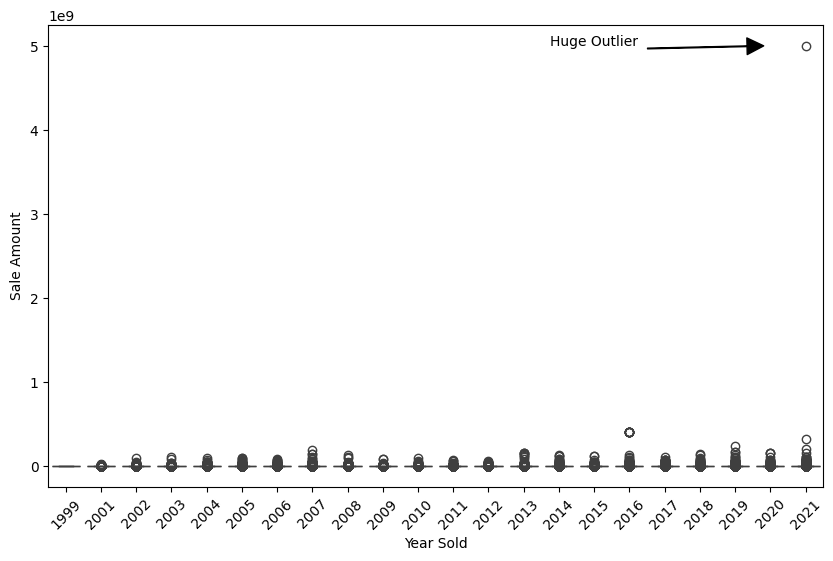

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_1,x='Year Sold',y='Sale Amount',)
plt.xticks(rotation=45)
plt.annotate('Huge Outlier', xy=(20, 5000000000), xytext=(15, 5000000000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=10, ha='center')

Text(0.5, 1.0, 'Average Sale Price by Year')

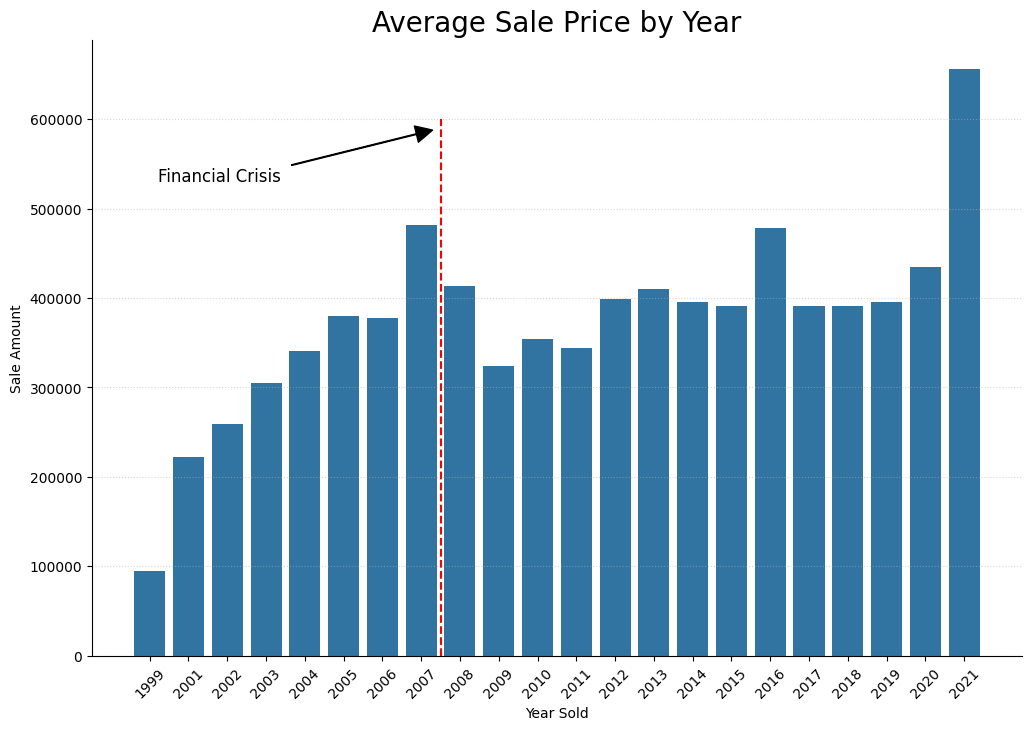

In [13]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_1,x='Year Sold',y='Sale Amount',errorbar=None)
plt.xticks(rotation=45)
plt.vlines(7.5,ymin=0,ymax=600000,ls='--',color='red')
plt.annotate('Financial Crisis', xy=(7.5, 590000), xytext=(1.8, 530000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=12, ha='center')
sns.despine(top=True, right=True)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.title('Average Sale Price by Year',fontsize=20)

Text(0.5, 1.0, 'Amount of Houses Sold by Year')

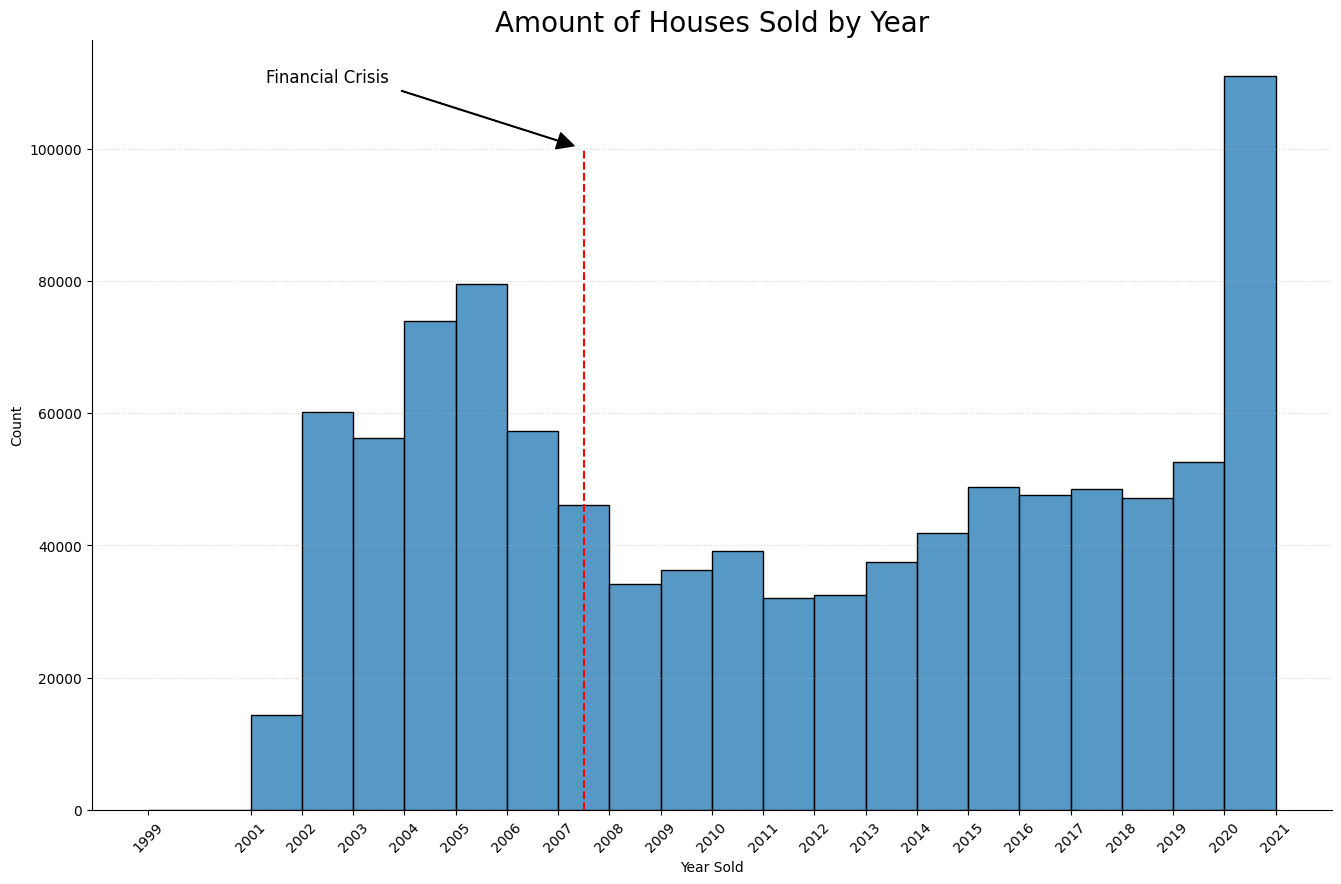

In [14]:
plt.figure(figsize=(16,10))
sns.histplot(data=df_1,x='Year Sold',bins=22)
plt.xticks(df_1['Year Sold'].unique(),rotation=45)
plt.xticks(rotation=45)
plt.vlines(2007.5,ymin=0,ymax=100000,ls='--',color='red')
plt.annotate('Financial Crisis', xy=(2007.5, 100000), xytext=(2002.5, 110000),
             arrowprops=dict(facecolor='black', shrink=0.05,width=0.5),
             fontsize=12, ha='center')
sns.despine(top=True, right=True)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.title('Amount of Houses Sold by Year',fontsize=20)

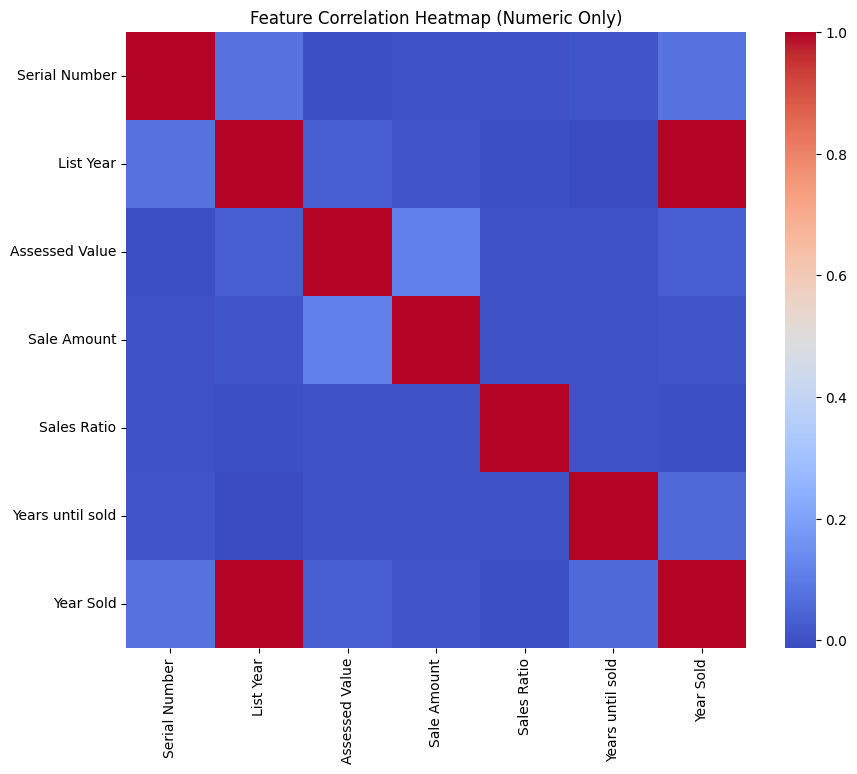

In [15]:
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap (Numeric Only)")
plt.show()



### Predict Model


In [29]:
#Import data 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import time


In [30]:
#Now define the target and features for that

target_col = 'Sale Amount'
X = df.drop(columns=[target_col])
y = df[target_col]

# --- Drop unnecessary columns (unique identifiers)
drop_cols = ['Serial Number', 'Address']
X = X.drop(columns=drop_cols, errors='ignore')

# --- Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

Numeric features: ['List Year', 'Assessed Value', 'Sales Ratio', 'Years until sold', 'Year Sold']
Categorical features: ['Date Recorded', 'Town', 'Property Type', 'Residential Type']


In [31]:
#Define preprocessing (one-hot encode categorical features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [32]:
#Split the data into the trainning dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
#Create the pipeline: preprocessing + model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [36]:
#Train the model
print("\nTraining the Linear Regression Model...")
start = time.time()
model.fit(X_train, y_train)
end = time.time()
print(f"Training time: {end - start:.2f} seconds")



Training the Linear Regression Model...
Training time: 10.11 seconds


In [39]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n📊 Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:,.2f}")


📊 Model Performance:
R² Score: 0.1298
RMSE: 2,027,573.57


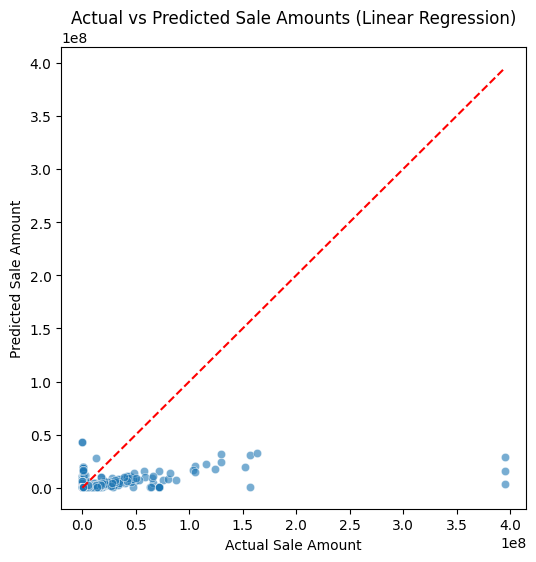

In [40]:
# --- Visualize actual vs predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Sale Amount")
plt.ylabel("Predicted Sale Amount")
plt.title("Actual vs Predicted Sale Amounts (Linear Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
